Setup Imports + device setup

In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, models
from torch import nn, optim
import pandas as pd

# Set this to the root of your project
project_root = "C:/Users/Varrick/material-defect-detection"
os.chdir(project_root)

# Use GPU if available
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


True
NVIDIA GeForce GTX 1080 Ti
Using device: cuda


Dataset paths and transforms

In [13]:
# Set paths
data_dir = "data/NEU-DET"
train_dir = "data/NEU-DET/train/images"
val_dir   = "data/NEU-DET/validation/images"

# Image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # convert grayscale → 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check class mapping
print("Classes:", train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
Train samples: 1440
Validation samples: 360


Verify a batch

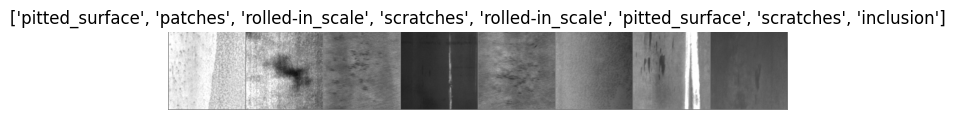

In [14]:
import numpy as np

def imshow(img, title=None):
    img = img * 0.5 + 0.5  # unnormalize from [-1, 1] to [0, 1]
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images[:8]), title=[train_dataset.classes[i] for i in labels[:8]])


Load ResNet18

In [15]:
from torchvision.models import resnet18, ResNet18_Weights

# Load pretrained ResNet18 with updated syntax
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Freeze all layers by default
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final ResNet block (layer4) - this improved performance to near 100% accuracy by epoch 2
for param in model.layer4.parameters():
    param.requires_grad = True

# Replace the final classification head for our 6-class problem
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)

model = model.to(device)

Training & validation loop

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(
    list(model.fc.parameters()) + list(model.layer4.parameters()), lr=0.0001
)

# Train loop
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(dataloader), correct / total

# Validation loop
def validate(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return val_loss / len(dataloader), correct / total

Train model

In [17]:
num_epochs = 5
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/5 - Train Loss: 0.2724, Train Acc: 0.9139 | Val Loss: 0.0917, Val Acc: 0.9722
Epoch 2/5 - Train Loss: 0.0181, Train Acc: 0.9972 | Val Loss: 0.0490, Val Acc: 0.9833
Epoch 3/5 - Train Loss: 0.0143, Train Acc: 0.9979 | Val Loss: 0.0336, Val Acc: 0.9889
Epoch 4/5 - Train Loss: 0.0120, Train Acc: 0.9972 | Val Loss: 0.0326, Val Acc: 0.9861
Epoch 5/5 - Train Loss: 0.0078, Train Acc: 0.9993 | Val Loss: 0.0255, Val Acc: 0.9917


Loss plot

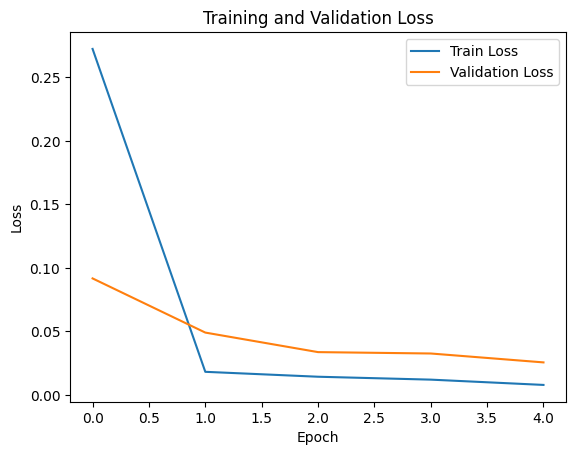

In [18]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

Accuracy curves

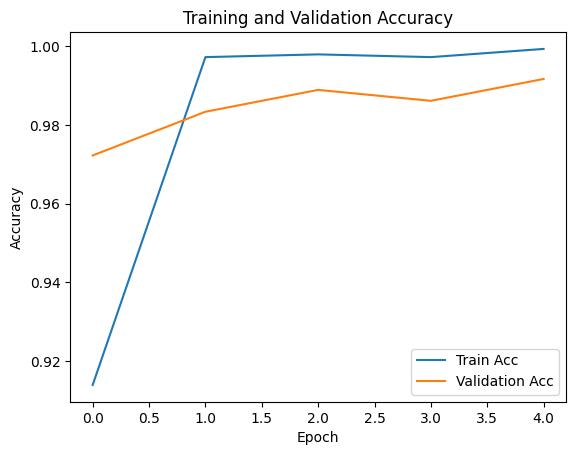

In [19]:
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Confusion matrix

<Figure size 800x600 with 0 Axes>

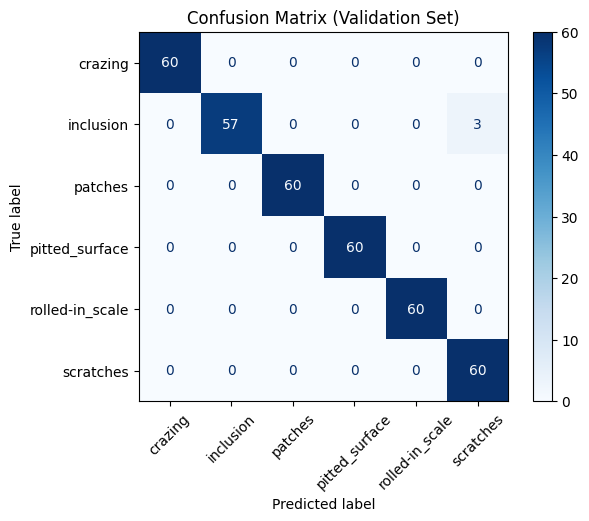

                 precision    recall  f1-score   support

        crazing       1.00      1.00      1.00        60
      inclusion       1.00      0.95      0.97        60
        patches       1.00      1.00      1.00        60
 pitted_surface       1.00      1.00      1.00        60
rolled-in_scale       1.00      1.00      1.00        60
      scratches       0.95      1.00      0.98        60

       accuracy                           0.99       360
      macro avg       0.99      0.99      0.99       360
   weighted avg       0.99      0.99      0.99       360



In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Make predictions on the validation set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)

# Plot it
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Validation Set)")
plt.show()

# Print precision, recall, f1-score for each class
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Save confusion matrix as image
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix (Validation Set)")
plt.savefig("confusion_matrix.png", bbox_inches="tight")
plt.close()

# Get report as a dictionary
report_dict = classification_report(all_labels, all_preds, target_names=train_dataset.classes, output_dict=True)

# Convert to DataFrame and save
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv("classification_report.csv", index=True)

Save model

In [21]:
torch.save(model.state_dict(), "models/resnet18_defect_classifier.pth")